<a href="https://colab.research.google.com/github/joymajumder23/template-digit-recognition/blob/main/1816_PR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Closest digit is 7


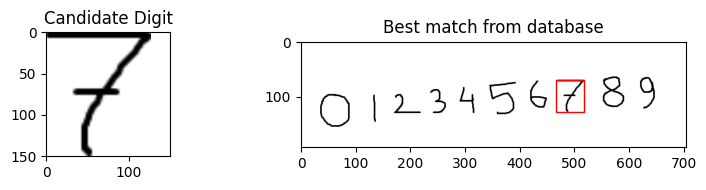

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define candidate image path
cand_img_path = '/content/drive/MyDrive/PR/777.png'

# Read canditate image
cand_img = cv2.imread(cand_img_path)

# Convert to grayscale
gray = cv2.cvtColor(cand_img, cv2.COLOR_BGR2GRAY)

# Apply adaptive threshold
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 11, 2)
# Find contour
cand_contour = cv2.findContours(
    thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Get cand_contour
cand_contour = cand_contour[0] if len(cand_contour) == 2 else cand_contour[1]

# Filter for useful cand_contour
cand_digit_contour = []
for contour in cand_contour:
    area = cv2.contourArea(contour)
    if area > 50:  # Filter by area
        cand_digit_contour.append(contour)

# Assume 1 digit per image
digit_contour = cand_digit_contour[0]

# Get bounding rectangle
[x, y, w, h] = cv2.boundingRect(digit_contour)

# Crop digit from image
cand_digit = cand_img[y:y+h, x:x+w]

# Resize template and test digits to 50x50
cand_digit_resized = cv2.resize(cand_digit, (50, 50))

# Normalize pixel values
normalized = cand_digit_resized / 255.0

# Flatten normalized digit to 1D array
cand_digit_vector = normalized.flatten()
cand_digit_array = np.array(cand_digit_vector)

# Define test image with 10 digits
test_img_path = '/content/drive/MyDrive/PR/Template02.png'

# Read test image
test_img = cv2.imread(test_img_path)

# Convert to grayscale
gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

# Apply adaptive threshold
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 11, 2)

# Find contours
contours = cv2.findContours(
    thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Get contours
contours = contours[0] if len(contours) == 2 else contours[1]

# Filter for useful contours
digit_contours = []
for contour in contours:
    area = cv2.contourArea(contour)
    if area > 50:  # Filter by area
        digit_contours.append(contour)

# Initialize digit vectors, and labels
digit_vectors = []
digit_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Extract digit vectors
for contour in digit_contours:

    # Get bounding box
    [x, y, w, h] = cv2.boundingRect(contour)

    # Crop digit from image
    digit = test_img[y:y+h, x:x+w]

    # Resize digit to 50x50
    resized = cv2.resize(digit, (50, 50))

    # Normalize pixel values
    normalized = resized / 255.0

    # Flatten resized digit
    digit_vector = normalized.flatten()

    digit_vectors.append(digit_vector)

# Normalize pixel values of the candidate digit
cand_digit_array_normalized = (cand_digit_array - np.mean(cand_digit_array)) / np.std(cand_digit_array)

# Calculate normalized cross-correlation for each digit vector
max_ncc = -float("inf")
closest_digit = None

for i in range(len(digit_vectors)):

    # Get current digit vector
    digit_vector = digit_vectors[i]

    # Convert to numpy array (no need to reshape here)
    digit_array = np.array(digit_vector)

    # Normalize pixel values of the current digit
    digit_array_normalized = (digit_array - np.mean(digit_array)) / np.std(digit_array)

    # Calculate the NCC value using np.corrcoef
    corr_matrix = np.corrcoef(cand_digit_array_normalized, digit_array_normalized)
    ncc = corr_matrix[0, 1]

    # Check if current NCC is highest (using absolute value)
    if (ncc) >= max_ncc:
        max_ncc = (ncc)
        closest_digit = digit_labels[i]

print(f"Closest digit is {closest_digit}")

# Candidate subplot dimensions
cand_w = 150
cand_h = 150

# Get original candidate digit shape
h, w = cand_digit.shape[:2]

# Calculate scale factor
scale_w = cand_w / w
scale_h = cand_h / h
scale = min(scale_w, scale_h)

# Resize candidate digit
cand_digit_resized = cv2.resize(cand_digit, None, fx=scale, fy=scale)

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 2))

# Candidate digit subplot
axes[0].imshow(cand_digit_resized, cmap='gray')
axes[0].set_title('Candidate Digit')
axes[0].set_xlim(0, cand_w)
axes[0].set_ylim(cand_h, 0)

# Best match subplot
axes[1].imshow(test_img, cmap='gray')
axes[1].set_title('Best match from database')

# Draw rectangle
[x, y, w, h] = cv2.boundingRect(digit_contours[closest_digit])
rect = plt.Rectangle((x, y), w, h, edgecolor='r', facecolor='none')
axes[1].add_patch(rect)

plt.tight_layout()
plt.show()